# CNN model

In [1]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, save_img
from keras.utils import to_categorical

data = np.load('data.npy')
target = np.load('target.npy')

# Identify the minority class (assuming 'Healthy' class is the minority)
minority_class = 1  # Assuming 1 corresponds to the 'Healthy' class
minority_class_data = data[target[:, minority_class] == 1]

# Directory to save augmented images
save_dir = 'augmented_images'
os.makedirs(save_dir, exist_ok=True)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

num_augmented_images = 10  # Number of augmented images per original image
augmented_data = []
augmented_target = []

for img_array in minority_class_data:
    img_array = np.expand_dims(img_array, axis=0)
    augmented_iter = datagen.flow(img_array, batch_size=1)
    for _ in range(num_augmented_images):
        aug_img = next(augmented_iter)[0]
        augmented_data.append(aug_img)
        augmented_target.append(to_categorical(minority_class, num_classes=target.shape[1]))

augmented_data = np.array(augmented_data)
augmented_target = np.array(augmented_target)

# Combine augmented data with original data
data = np.concatenate((data, augmented_data), axis=0)
target = np.concatenate((target, augmented_target), axis=0)

print(data.shape)
print(target.shape)



(870, 150, 150, 3)
(870, 2)


In [2]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Split testing set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Load the test set
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')


Training set size: 696
Validation set size: 87
Testing set size: 87


In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras import optimizers, losses
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=X_train.shape[1:], padding='same', kernel_initializer='orthogonal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (5, 5), kernel_initializer='orthogonal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), kernel_initializer='orthogonal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(target.shape[1], activation='sigmoid'))

model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['accuracy'])

# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 150, 150, 16)      0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 71, 71, 32)        12832     
                                                                 
 batch_normalization_13 (Ba  (None, 71, 71, 32)       

Average Training Loss: 0.4286382419091684
Average Training Accuracy: 0.9310344832914846
Average Validation Loss: 0.753234698816582
Average Validation Accuracy: 0.9003831413057115


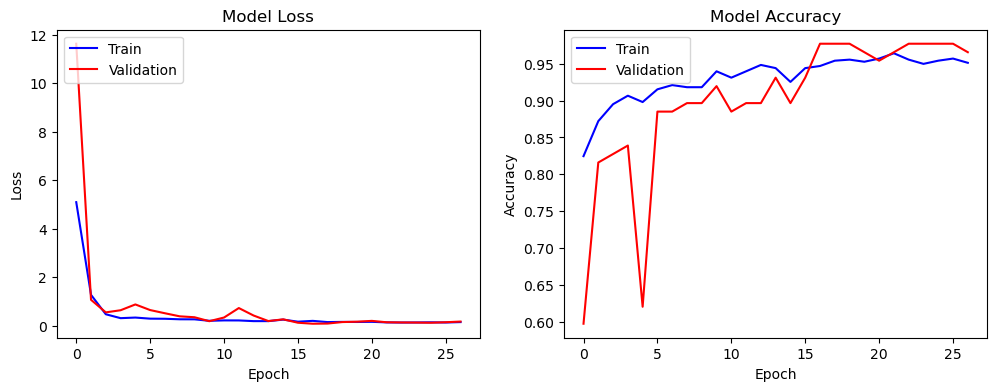

In [8]:


import matplotlib.pyplot as plt

avg_train_loss = np.mean(history.history['loss'])
avg_train_accuracy = np.mean(history.history['accuracy'])
avg_val_loss = np.mean(history.history['val_loss'])
avg_val_accuracy = np.mean(history.history['val_accuracy'])

print("Average Training Loss:", avg_train_loss)
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Loss:", avg_val_loss)
print("Average Validation Accuracy:", avg_val_accuracy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

model.save('my_model.keras')
